# Study into potential correlation between business survival and industry affiliation

## Part I. Introduction

Let's start by looking at the data:

In [1]:
# Here we are downloading some libraries
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import chi2

# This allows us to view the whole table
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

averages_data = pd.read_csv("averages.csv")

averages_data.head()

,Industry,Year_After_Establishment,Avg_Survival_Rate
0,accommodation_and_food_services.txt,0,100.000000
1,accommodation_and_food_services.txt,1,82.693103
2,accommodation_and_food_services.txt,2,72.128571
3,accommodation_and_food_services.txt,3,64.485185
4,accommodation_and_food_services.txt,4,58.300000


We can note the following:

The industry column shows the industry affiliation;
The second column shows the year after establishment;
The last column shows the average survival rate in the industry. 

That means for the last column we took the survival rate of businesses in the accommodation industry in 1994, 1995, 1996, ... up to 2023, and calculated the average of them. 

The calculation part is done in the *industries.py* file. Please check it out, if needed. 


## Part II. Initial Exploration

With that done, let's graph how those average survival rates behave some years after establishment:

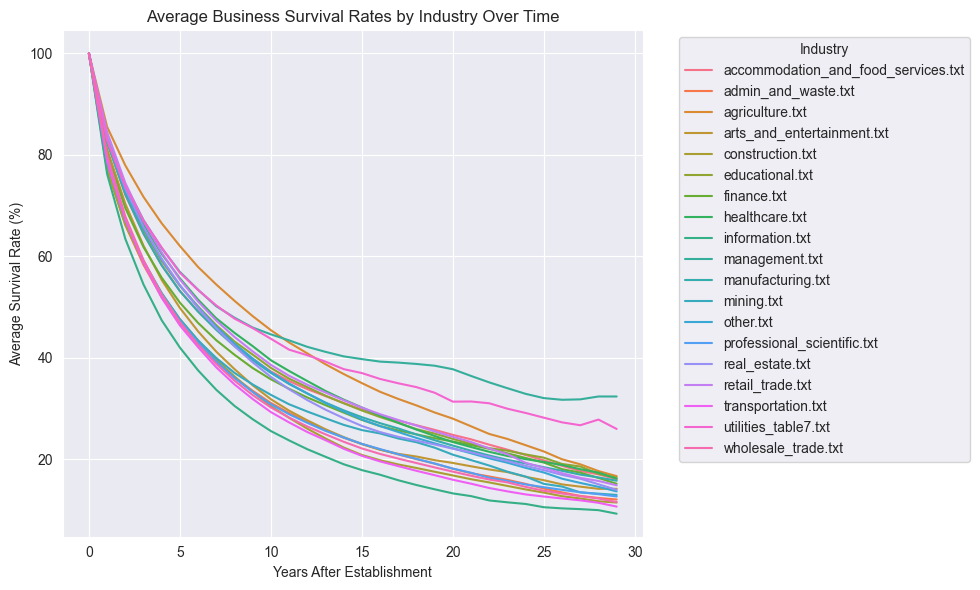

In [2]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year_After_Establishment', y='Avg_Survival_Rate', hue='Industry', data=averages_data, legend=True)
plt.title('Average Business Survival Rates by Industry Over Time')
plt.xlabel('Years After Establishment')
plt.ylabel('Average Survival Rate (%)')
plt.grid(True)
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

This graphs shows a couple of important points:

1. We can see that, in general, the graph follows 1/x function. That means we should make a transformation before applying the linear mixed model.
2. Some industries show different survival rates: *information* sector is consistently one of the lowest, while *agriculture*, *management*, and *utilities* are the highest ones. 

## Part III. Transformation

Let's apply the transformation first:

In [3]:
averages_data['log_Avg_Survival_Rate'] = np.log(averages_data['Avg_Survival_Rate'])

print(averages_data.head())

                              Industry  Year_After_Establishment  \
0  accommodation_and_food_services.txt                         0   
1  accommodation_and_food_services.txt                         1   
2  accommodation_and_food_services.txt                         2   
3  accommodation_and_food_services.txt                         3   
4  accommodation_and_food_services.txt                         4   

   Avg_Survival_Rate  log_Avg_Survival_Rate  
0         100.000000               4.605170  
1          82.693103               4.415136  
2          72.128571               4.278450  
3          64.485185               4.166436  
4          58.300000               4.065602  


That makes sense: e^(4.6) ~ 100, which corresponds to 100% survival rate around the first year after an establishment of business.  

With the transformation completed, let's see how the graph looks like and try to create the mixed effect model!

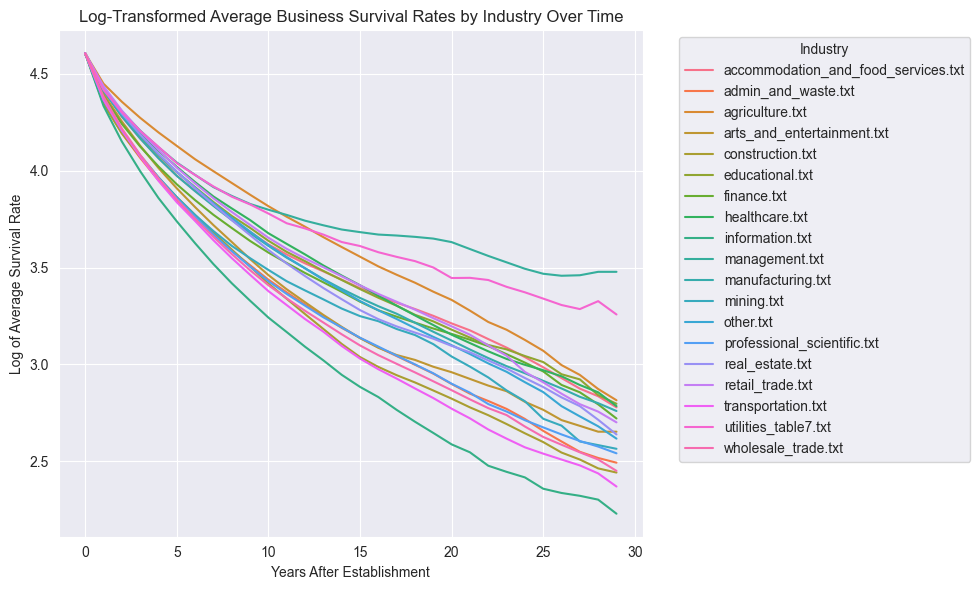

In [4]:
# Create a plot for the log-transformed average survival rates for each industry over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year_After_Establishment', y='log_Avg_Survival_Rate', hue='Industry', data=averages_data, legend=True)
plt.title('Log-Transformed Average Business Survival Rates by Industry Over Time')
plt.xlabel('Years After Establishment')
plt.ylabel('Log of Average Survival Rate')
plt.grid(True)
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

It is much more linear than what we had before.

## Part IV. Initial Model

Let's apply the Linear Mixed Model. Our setup can be described this way:

- **Fixed effect**: Time;
- **Random effect**: Industry affiliation.

Let's try the simple model:

In [5]:
# Fit a Linear Mixed Model with Year_After_Establishment as the fixed effect and Industry as the random effect
lin_mix_model = smf.mixedlm(formula="log_Avg_Survival_Rate ~ Year_After_Establishment",
                            data=averages_data,
                            # re_formula='~Year_After_Establishment',
                            groups=averages_data["Industry"]).fit()

# Display the summary of the new LMM result
print(lin_mix_model.summary())

               Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: log_Avg_Survival_Rate
No. Observations:  570     Method:             REML                 
No. Groups:        19      Scale:              0.0198               
Min. group size:   30      Log-Likelihood:     265.1256             
Max. group size:   30      Converged:          Yes                  
Mean group size:   30.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 4.259    0.042 100.783 0.000  4.176  4.342
Year_After_Establishment -0.058    0.001 -85.726 0.000 -0.060 -0.057
Group Var                 0.031    0.077                            



Let's try to make sense of the output.

The number of groups is 19, which corresponds with the 19 industries from the Bureau of Labor Statistics. 
There are 30 observations in one group because there has passed 29 years since 1994, and we add the zeroth year with 100%.

The scale value (0.1971) corresponds to the variance of the residuals. Group Variance (0.031) is self-explanatory. With this knowledge we can calculate 
how much variance is explained by the Industry Random Effect:

In [6]:
0.031/(0.031 + 0.0198)

0.610236220472441

More than 61% of the variance can be explained with the industry variation.

As of the other parts of the output, the p-value for the model can be found at the lower part of the output (it is Pr>|z|), and it is much less than any alpha-level. 
That means time does play a statistically significant role in the survival rates—which is fairly obvious.
The coefficient of -0.058 means that for every additional year after an establishment, the log survival rate decreases by 0.058.

To assess the random and fixed effects in detail, let's look into the Fixed and Random effects outputs:

In [7]:
print("Fixed effect:")
print("Intercept: ", lin_mix_model.params['Intercept'])
print("Year_After_Establishment: ", lin_mix_model.params['Year_After_Establishment'])

print("\nRandom effect:")
print(lin_mix_model.random_effects)

Fixed effect:
Intercept:  4.259048820913243
Year_After_Establishment:  -0.058302535269776565

Random effect:
{'accommodation_and_food_services.txt': Group    0.082567
dtype: float64, 'admin_and_waste.txt': Group   -0.137932
dtype: float64, 'agriculture.txt': Group    0.201896
dtype: float64, 'arts_and_entertainment.txt': Group   -0.084093
dtype: float64, 'construction.txt': Group   -0.18048
dtype: float64, 'educational.txt': Group    0.085468
dtype: float64, 'finance.txt': Group    0.037858
dtype: float64, 'healthcare.txt': Group    0.089671
dtype: float64, 'information.txt': Group   -0.342959
dtype: float64, 'management.txt': Group    0.36219
dtype: float64, 'manufacturing.txt': Group    0.044943
dtype: float64, 'mining.txt': Group   -0.067518
dtype: float64, 'other.txt': Group    0.023164
dtype: float64, 'professional_scientific.txt': Group   -0.1303
dtype: float64, 'real_estate.txt': Group    0.018876
dtype: float64, 'retail_trade.txt': Group    0.07862
dtype: float64, 'transportati

The 'Group' value in the Random effect section shows the adjustments for each industry relative to the overall trend. Let's interpret a few examples:

- **utilities: Group (0.286759)**: this industry has one of the larger positive deviations, meaning businesses here survive better than the overall trend;
- **information: Group (-0.342959)**: this industry has a larger negative random effect, indicating that businesses in this sector tend to have significantly worse survival rates.

## Part V. Likelihood Ratio Test

To check how significant the random effect of industry is, let's conduct a Likelihood Ratio Test (LRT). 

In [8]:
# Fit a simpler model without the random effect (only fixed effects)
lmm_fixed_only = smf.ols("log_Avg_Survival_Rate ~ Year_After_Establishment", data=averages_data).fit()

# Calculate the likelihood ratio statistic
lr_stat = 2 * (lin_mix_model.llf - lmm_fixed_only.llf)

# Calculate the degrees of freedom (difference in the number of parameters)
df_diff = lin_mix_model.df_modelwc - lmm_fixed_only.df_model

# Perform the likelihood ratio test
p_value = chi2.sf(lr_stat, df_diff)

# Return the test statistic and p-value
print(lr_stat, p_value)

434.06100985133594 5.557114000071269e-95


The p-value is minimal (much less than 0.05), which indicates that the random effect (industry) is highly significant. 
This means that incorporating the random effect for industries significantly improves the model fit compared to a model with only the fixed effect (time after an establishment).

Now let's do the repeat of the process with an interaction term.

# Part VI. LMM with an interaction term

Here we are going to add the interaction term. Due to the library we are using, it is not explicitly stated in the formula. Instead,
it can be seen in the *re_formula* argument. 

In [9]:
# Fit a Linear Mixed Model with Year_After_Establishment as the fixed effect and Industry as the random effect
lin_mix_model = smf.mixedlm(formula="log_Avg_Survival_Rate ~ Year_After_Establishment",
                            re_formula="~1+Year_After_Establishment",
                            data=averages_data,
                            groups=averages_data["Industry"]).fit()
print(lin_mix_model.summary())

                     Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     log_Avg_Survival_Rate
No. Observations:      570         Method:                 REML                 
No. Groups:            19          Scale:                  0.0131               
Min. group size:       30          Log-Likelihood:         370.9604             
Max. group size:       30          Converged:              Yes                  
Mean group size:       30.0                                                     
--------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             4.259    0.016 272.192 0.000  4.228  4.290
Year_After_Establishment             -0.058    0.002 -25.959 0.000 -0.063 -0.054
Group Var                             0.003    0.0

/Users/ha/PycharmProjects/bs/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In the similar fashion, let's try to see how much variance can be explained by the random factor:

In [10]:
0.003/(0.003 + 0.0131)

0.1863354037267081

As you can see, other rows (Group x Year_After_Establishment, or Year_After_Establishment Var) have 0. That means they do not contribute to the model.

The amount of variance explained by the random effect is somewhat higher than 18%. 

In [12]:
print("Fixed effect:")
print(lin_mix_model.params)

print("\nRandom effect:")
print(lin_mix_model.random_effects)

Fixed effect:
Intercept                               4.259049
Year_After_Establishment               -0.058303
Group Var                               0.227369
Group x Year_After_Establishment Cov    0.025583
Year_After_Establishment Var            0.006854
dtype: float64

Random effect:
{'accommodation_and_food_services.txt': Group                       0.021099
Year_After_Establishment    0.004268
dtype: float64, 'admin_and_waste.txt': Group                      -0.041390
Year_After_Establishment   -0.006563
dtype: float64, 'agriculture.txt': Group                       0.095015
Year_After_Establishment    0.006425
dtype: float64, 'arts_and_entertainment.txt': Group                      -0.028709
Year_After_Establishment   -0.003680
dtype: float64, 'construction.txt': Group                      -0.046565
Year_After_Establishment   -0.009289
dtype: float64, 'educational.txt': Group                       0.024235
Year_After_Establishment    0.004197
dtype: float64, 'finance.txt': Grou